In [86]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow.examples.tutorials.mnist import input_data
#For binarizing the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder() 
lb = preprocessing.LabelBinarizer()

#importing the Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

# HELPER FUNCTIONS

def shuffle(data, target):
    index = np.arange(0, len(data))
    np.random.shuffle(index)
    shuffled_data = [data[i] for i in index]
    shuffled_target = [target[i] for i in index]
    return np.asarray(shuffled_data), np.asarray(shuffled_target)

In [76]:
def my_leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.1)

In [89]:
#QUESTION 1.2.1  
def part1_train(n_epoch,learning_rate,batch_size,no_progress_limit,n_hidden,activation_type,moment):
    tf.reset_default_graph()
    #for Part 1:
    X_train1 = X_train[y_train < 5]
    y_train1 = y_train[y_train < 5]
    lb.fit(y_train1)
    y_train1_binary = lb.transform(y_train1)

    m, n = X_train1.shape

    X_valid1 = X_valid[y_valid < 5]
    y_valid1 = y_valid[y_valid < 5]
    lb.fit(y_valid1)
    y_valid1_binary = lb.transform(y_valid1)

    X_test1 = X_test[y_test < 5]
    y_test1 = y_test[y_test < 5]
    lb.fit(y_test1)
    y_test1_binary= lb.transform(y_test1)


    #Test Data 
    x_in = tf.placeholder(tf.float32,[None,n], name="dataset_in")
    y_in = tf.placeholder(tf.float32, [None,5], name="true_value")
    #for batchedNormalization
    training = tf.placeholder_with_default(False, shape=(), name= 'training')
    momentum = tf.placeholder_with_default(0.85, shape=(), name ='BN_momentum')
    #5 layer NN setup
    he_init = tf.contrib.layers.variance_scaling_initializer()
    #activation_type goes from 0 to 2 for elu, relu, or leaky relu w/ alpha 0.1
    if activation_type == 0:
        hidden1 = tf.layers.dense(x_in, n_hidden, activation=tf.nn.elu, 
                                kernel_initializer=he_init, name="hidden1")
        hidden2 = tf.layers.dense(hidden1, n_hidden, activation=tf.nn.elu,
                                kernel_initializer=he_init, name="hidden2")
        hidden3 = tf.layers.dense(hidden2, n_hidden, activation=tf.nn.elu,
                                kernel_initializer=he_init, name="hidden3")
        hidden4 = tf.layers.dense(hidden3, n_hidden, activation=tf.nn.elu,
                                kernel_initializer=he_init, name="hidden4")
        hidden5 = tf.layers.dense(hidden4, n_hidden, activation=tf.nn.elu,
                                kernel_initializer=he_init, name="hidden5")
    elif activation_type == 1:
        hidden1 = tf.layers.dense(x_in, n_hidden, activation=tf.nn.relu, 
                                kernel_initializer=he_init, name="hidden1")
        hidden2 = tf.layers.dense(hidden1, n_hidden, activation=tf.nn.relu,
                                kernel_initializer=he_init, name="hidden2")
        hidden3 = tf.layers.dense(hidden2, n_hidden, activation=tf.nn.relu,
                                kernel_initializer=he_init, name="hidden3")
        hidden4 = tf.layers.dense(hidden3, n_hidden, activation=tf.nn.relu,
                                kernel_initializer=he_init, name="hidden4")
        hidden5 = tf.layers.dense(hidden4, n_hidden, activation=tf.nn.relu,
                                kernel_initializer=he_init, name="hidden5")
    elif activation_type==2:
        hidden1 = tf.layers.dense(x_in, n_hidden, activation=my_leaky_relu, 
                                kernel_initializer=he_init, name="hidden1")
        hidden2 = tf.layers.dense(hidden1, n_hidden, activation=my_leaky_relu,
                                kernel_initializer=he_init, name="hidden2")
        hidden3 = tf.layers.dense(hidden2, n_hidden, activation=my_leaky_relu,
                                kernel_initializer=he_init, name="hidden3")
        hidden4 = tf.layers.dense(hidden3, n_hidden, activation=my_leaky_relu,
                                kernel_initializer=he_init, name="hidden4")
        hidden5 = tf.layers.dense(hidden4, n_hidden, activation=my_leaky_relu,
                                kernel_initializer=he_init, name="hidden5")
    else:
        #assuming they dont use another value other than 0,1,2,3
        hidden1 = tf.layers.dense(x_in, n_hidden, kernel_initializer=he_init, name="hidden1")
        bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=momentum)
        bn1_act = tf.nn.elu(bn1)
        
        hidden2 = tf.layers.dense(bn1_act, n_hidden,kernel_initializer=he_init, name="hidden2")
        bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=momentum)
        bn2_act = tf.nn.elu(bn2)
        
        hidden3 = tf.layers.dense(bn2_act, n_hidden,kernel_initializer=he_init, name="hidden3")
        bn3 = tf.layers.batch_normalization(hidden3, training=training, momentum=momentum)
        bn3_act = tf.nn.elu(bn3)
        
        hidden4 = tf.layers.dense(bn3_act, n_hidden,kernel_initializer=he_init, name="hidden4")
        bn4 = tf.layers.batch_normalization(hidden4, training=training, momentum=momentum)
        bn4_act = tf.nn.elu(bn4)
        
        hidden5 = tf.layers.dense(bn4_act, n_hidden,kernel_initializer=he_init, name="hidden5")
        bn5 = tf.layers.batch_normalization(hidden5, training=training, momentum=momentum)
        hidden5 = tf.nn.elu(bn5)
        
    output = tf.layers.dense(hidden5, 5,kernel_initializer=he_init, name="output")
    
    cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_in)
    total_loss = tf.reduce_mean(cross_entropy_loss,name = 'loss_func')
    #Saver
    saver = tf.train.Saver()
    
    #Train
    Adam_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)


    #Validation and Data Loggers
    #_, train_acc_log = tf.metrics.accuracy(labels=y_in, predictions=tf.round(tf.sigmoid(y_pred)))
    correct_prediction= tf.equal(tf.argmax(output,1),tf.argmax(y_in,1),name = 'correct_pred')
    acc = tf.reduce_mean(tf.cast(correct_prediction,tf.float32),name='acc')
    err = 1-acc
    
    #for finding a classification error
    out_soft = tf.nn.softmax(output)
    
    #initialized all vars
    init = tf.global_variables_initializer()
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    #run!
    with tf.Session() as sess:
        max_checks_without_progress = no_progress_limit
        checks_without_progress = 0
        
        #for logging our data
        validation_loss = np.zeros(n_epoch)
        validation_err = np.zeros(n_epoch)
        train_loss_total = np.zeros(n_epoch)
        train_err_total = np.zeros(n_epoch)
        
        best_loss = np.inf
        
    
        sess.run(init)
        for epoch in range(n_epoch):
            train_loss = 0
            train_err = 0
            #reshuffles the dataset in unison. for each epoch
            X_train1, y_train1_binary = shuffle(X_train1,y_train1_binary)
            for offset in range(0, m, batch_size):
                #find the proper dataset
                batch_x = X_train1[offset:offset+batch_size]
                batch_y = y_train1_binary[offset:offset+batch_size]
                if activation_type == 3:
                    sess.run([Adam_optimizer,extra_update_ops],feed_dict={x_in:batch_x.reshape(-1,n),
                                                                          y_in:batch_y,
                                                                          training:True,
                                                                          momentum:moment})                    
                else:
                    sess.run([Adam_optimizer],feed_dict={x_in:batch_x.reshape(-1,n),
                                                         y_in:batch_y})
                #storing our loss per batch
                train_loss = train_loss + sess.run(total_loss,feed_dict={x_in:batch_x.reshape(-1,n),
                                                                         y_in:batch_y})
                train_err = train_err + sess.run(err,feed_dict={x_in:batch_x.reshape(-1,n),
                                                                y_in:batch_y})
                
            #calculating the average loss per epoch
            train_loss_total[epoch] = train_loss/(m/batch_size)
            train_err_total[epoch]=train_err/(m/batch_size)
            
            validation_loss[epoch],validation_err[epoch]= sess.run([total_loss, err],
                                                                   feed_dict={x_in:X_valid1,y_in:y_valid1_binary})
            
            if (validation_loss[epoch] < best_loss):
                save_path = saver.save(sess, "./model.ckpt")
                step_count = 0
                best_loss = validation_loss[epoch]
            else:
                step_count += 1
                if step_count > no_progress_limit:
                    print("Early stopping epoch:{} at loss:{}".format(epoch,best_loss))
                    
                    #truncates array to remove all the excess 0's (preprocessing for plotting)
                    train_loss_total = np.array(train_loss_total[0:epoch])
                    train_err_total = np.array(train_err_total[0:epoch])
                    validation_loss = np.array(validation_loss[0:epoch])
                    validation_err = np.array(validation_err[0:epoch])
                    break
        test_err,out = sess.run([err,out_soft],feed_dict={x_in:X_test1,y_in:y_test1_binary})
        
        #test_acc outputs the error based on test data
        #out returns the output prediction (needed to find an example for misclassification)
        return train_loss_total, train_err_total, validation_loss, validation_err,test_err,out

Early stopping epoch:31 at loss:0.040299028158187866


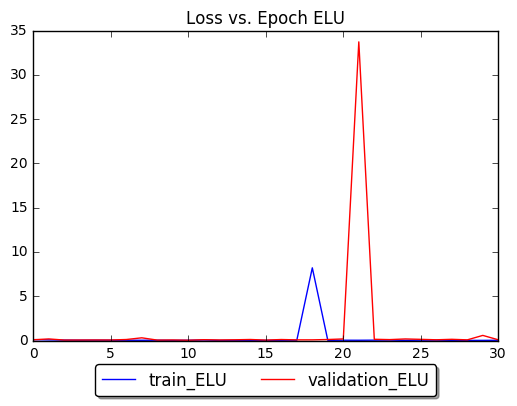

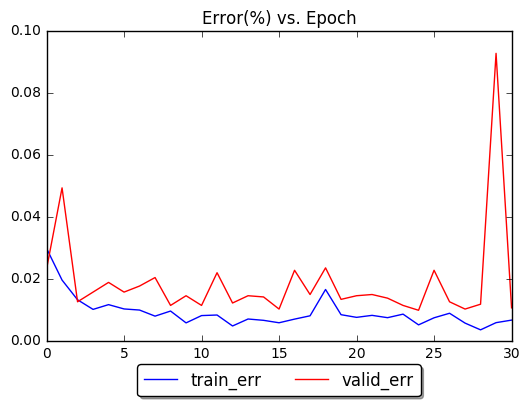

ELU: Max Train Error= 0.029745351036075042 Max Validation Error= 0.09265053272247314 Test err= 0.007978201
Early stopping epoch:31 at loss:0.03991810232400894


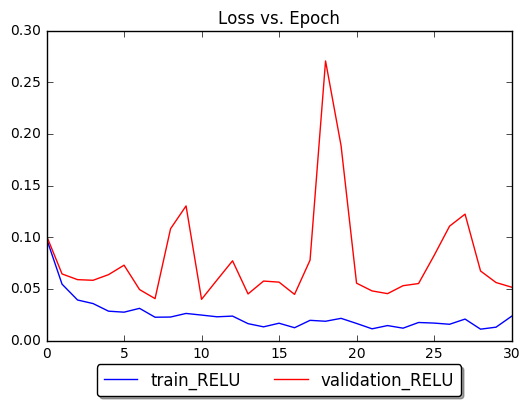

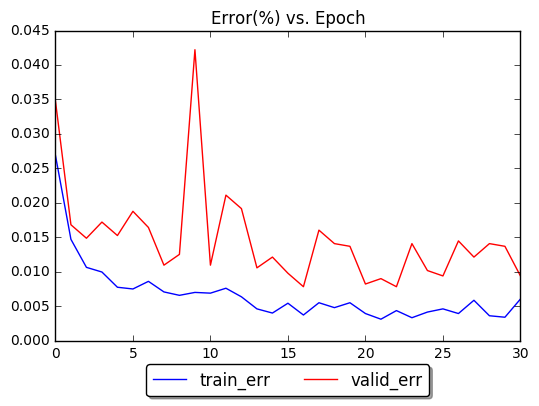

RELU: Max  Train Error= 0.026896042680594097 Max Validation Error= 0.042220473289489746 Test err= 0.008756578
Early stopping epoch:76 at loss:4.47572660446167


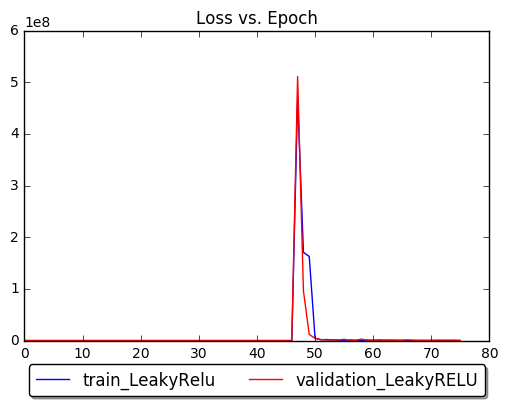

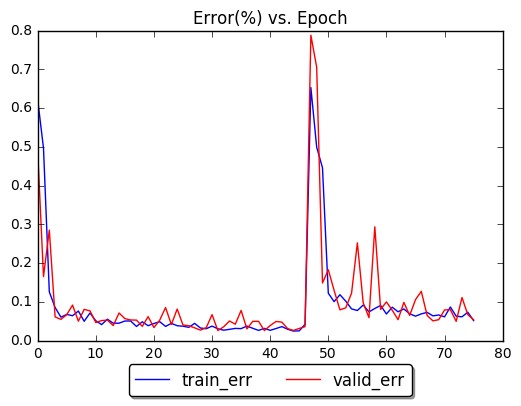

Leaky RELU: Max  Train Error= 0.6529202865324667 Max Validation Error= 0.7881157398223877 Test err= 0.039696455


In [83]:
#FOR QUESTION: 1.2.2 Hyperparameters
learning_rate = 0.005
batch_size = 20
n_hidden=100
n_epoch = 1000
max_no_progress = 20
activation_type = 0 #for elu
moment = 0
train_loss, train_err, valid_loss, valid_err,test_err, test_prediction= part1_train(n_epoch,
                                                                                    learning_rate,
                                                                                    batch_size,
                                                                                    max_no_progress,
                                                                                    n_hidden,activation_type,
                                                                                    moment)

import matplotlib.pyplot as p 
p.plot(train_loss,'b-', label="train_ELU")
p.plot(valid_loss,'r-',label ="validation_ELU")
p.title("Loss vs. Epoch ELU")
p.legend(numpoints=1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.show()

p.plot(train_err,'b-', label="train_err")
p.plot(valid_err,'r-',label ="valid_err")
p.legend(numpoints = 1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.title("Error(%) vs. Epoch")
p.show()

print("ELU: Max Train Error=",np.max(train_err),"Max Validation Error=",np.max(valid_err),"Test err=",test_err)



###FOR 1.2.3
learning_rate = 0.005
batch_size = 20
n_hidden = 50
n_epoch = 1000
max_no_progress = 20
activation_type = 1 #for relu

train_loss, train_err, valid_loss, valid_err,test_err, test_prediction= part1_train(n_epoch,
                                                                                    learning_rate,batch_size,
                                                                                    max_no_progress,
                                                                                    n_hidden,
                                                                                    activation_type,
                                                                                    moment)

p.plot(train_loss,'b-', label="train_RELU")
p.plot(valid_loss,'r-',label ="validation_RELU")
p.title("Loss vs. Epoch")
p.legend(numpoints=1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.show()

p.plot(train_err,'b-', label="train_err")
p.plot(valid_err,'r-',label ="valid_err")
p.legend(numpoints = 1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.title("Error(%) vs. Epoch")
p.show()

print("RELU: Max  Train Error=",np.max(train_err),"Max Validation Error=",np.max(valid_err),"Test err=",test_err)

#LEAKY RELU

learning_rate = 0.1
batch_size = 500
n_hidden = 140
n_epoch = 1000
max_no_progress = 30
activation_type = 2 #for leakyRelu

train_loss, train_err, valid_loss, valid_err,test_err, test_prediction= part1_train(n_epoch,
                                                                                    learning_rate,
                                                                                    batch_size,
                                                                                    max_no_progress,
                                                                                    n_hidden,
                                                                                    activation_type,
                                                                                    moment)

p.plot(train_loss,'b-', label="train_LeakyRelu")
p.plot(valid_loss,'r-',label ="validation_LeakyRELU")
p.title("Loss vs. Epoch")
p.legend(numpoints=1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.show()

p.plot(train_err,'b-', label="train_err")
p.plot(valid_err,'r-',label ="valid_err")
p.legend(numpoints = 1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.title("Error(%) vs. Epoch")
p.show()

print("Leaky RELU: Max Train Error=",np.max(train_err),"Max Validation Error=",np.max(valid_err),"Test err=",test_err)

Early stopping epoch:45 at loss:0.022783435881137848


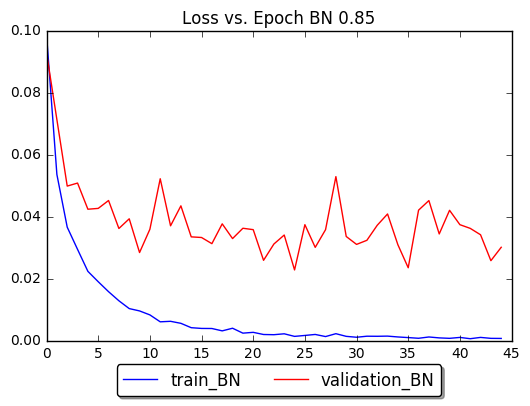

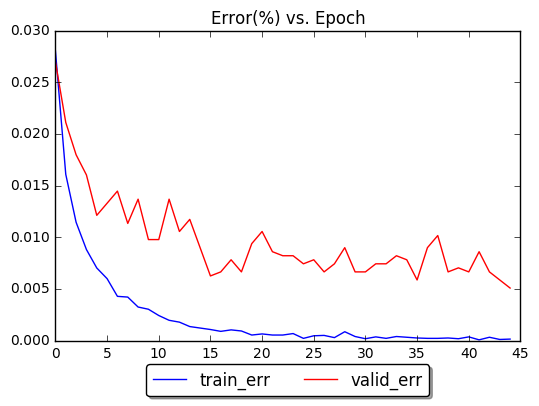

BN 0.85: Max Train Error= 0.028033388843804404 Max Validation Error= 0.026974201202392578 Test err= 0.006032288
Early stopping epoch:33 at loss:0.028175299987196922


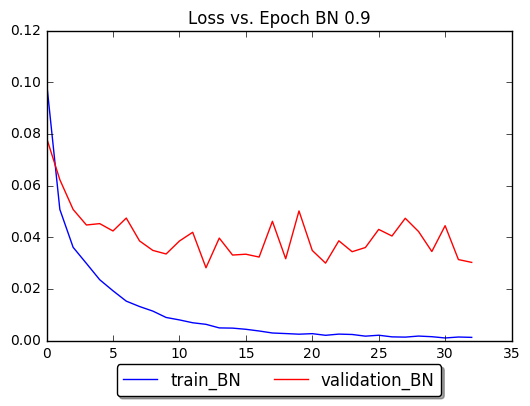

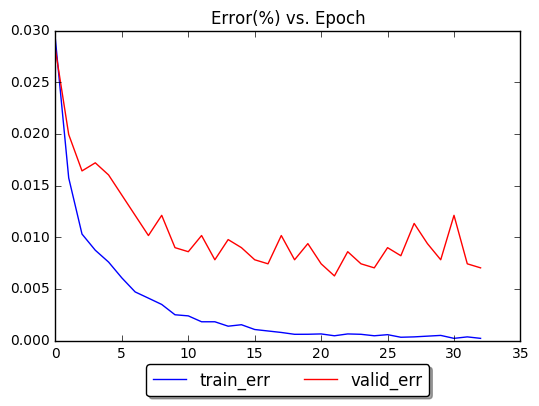

BN 0.9: Max Train Error= 0.029103365049220002 Max Validation Error= 0.028146982192993164 Test err= 0.0062268972
Early stopping epoch:33 at loss:0.022243745625019073


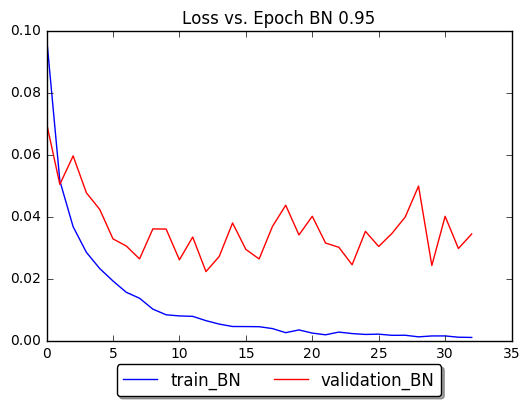

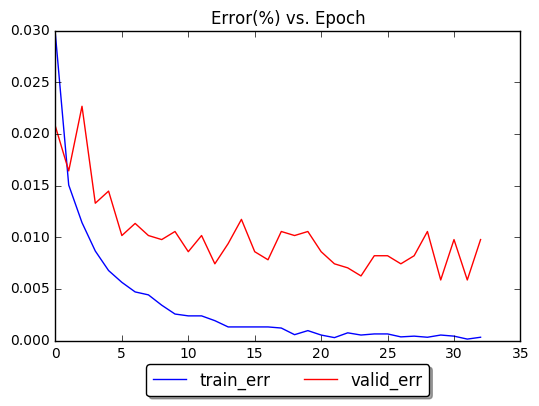

BN 0.95: Max Train Error= 0.029602687941679848 Max Validation Error= 0.022673964500427246 Test err= 0.0070052743
Early stopping epoch:48 at loss:0.012272619642317295


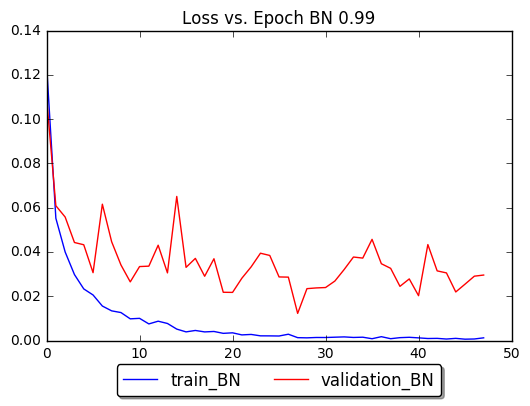

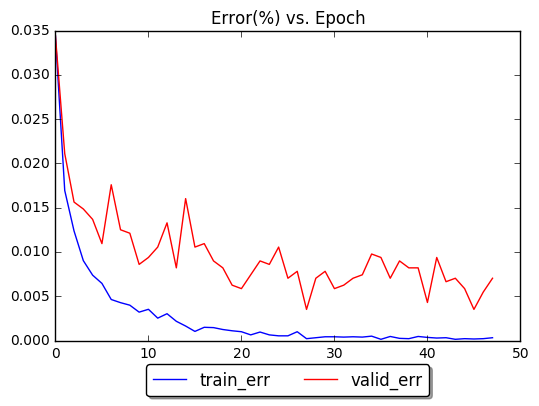

BN 0.99: Max Train Error= 0.03442154502773414 Max Validation Error= 0.034401893615722656 Test err= 0.0062268972


In [91]:
#1.2.4. Using the hyper params for 1.2.2
import matplotlib.pyplot as p 


learning_rate = 0.005
batch_size = 20
n_hidden=100
n_epoch = 1000
max_no_progress = 20
activation_type = 3 #for elu with BatchNormalization
moment = 0.85

train_loss, train_err, valid_loss, valid_err,test_err, test_prediction= part1_train(n_epoch,
                                                                                    learning_rate,
                                                                                    batch_size,
                                                                                    max_no_progress,
                                                                                    n_hidden,
                                                                                    activation_type,
                                                                                    moment)

p.plot(train_loss,'b-', label="train_BN")
p.plot(valid_loss,'r-',label ="validation_BN")
p.title("Loss vs. Epoch BN 0.85")
p.legend(numpoints=1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.show()

p.plot(train_err,'b-', label="train_err")
p.plot(valid_err,'r-',label ="valid_err")
p.legend(numpoints = 1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.title("Error(%) vs. Epoch")
p.show()

print("BN 0.85: Max Train Error=",np.max(train_err),"Max Validation Error=",np.max(valid_err),"Test err=",test_err)

moment = 0.9

train_loss, train_err, valid_loss, valid_err,test_err, test_prediction= part1_train(n_epoch,
                                                                                    learning_rate,
                                                                                    batch_size,
                                                                                    max_no_progress,
                                                                                    n_hidden,
                                                                                    activation_type,
                                                                                    moment)

p.plot(train_loss,'b-', label="train_BN")
p.plot(valid_loss,'r-',label ="validation_BN")
p.title("Loss vs. Epoch BN 0.9")
p.legend(numpoints=1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.show()

p.plot(train_err,'b-', label="train_err")
p.plot(valid_err,'r-',label ="valid_err")
p.legend(numpoints = 1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.title("Error(%) vs. Epoch")
p.show()

print("BN 0.9: Max Train Error=",np.max(train_err),"Max Validation Error=",np.max(valid_err),"Test err=",test_err)

moment = 0.95

train_loss, train_err, valid_loss, valid_err,test_err, test_prediction= part1_train(n_epoch,
                                                                                    learning_rate,
                                                                                    batch_size,
                                                                                    max_no_progress,
                                                                                    n_hidden,
                                                                                    activation_type,
                                                                                    moment)

p.plot(train_loss,'b-', label="train_BN")
p.plot(valid_loss,'r-',label ="validation_BN")
p.title("Loss vs. Epoch BN 0.95")
p.legend(numpoints=1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.show()

p.plot(train_err,'b-', label="train_err")
p.plot(valid_err,'r-',label ="valid_err")
p.legend(numpoints = 1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.title("Error(%) vs. Epoch")
p.show()

print("BN 0.95: Max Train Error=",np.max(train_err),"Max Validation Error=",np.max(valid_err),"Test err=",test_err)




moment = 0.99

train_loss, train_err, valid_loss, valid_err,test_err, test_prediction= part1_train(n_epoch,
                                                                                    learning_rate,
                                                                                    batch_size,
                                                                                    max_no_progress,
                                                                                    n_hidden,
                                                                                    activation_type,
                                                                                    moment)

p.plot(train_loss,'b-', label="train_BN")
p.plot(valid_loss,'r-',label ="validation_BN")
p.title("Loss vs. Epoch BN 0.99")
p.legend(numpoints=1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.show()

p.plot(train_err,'b-', label="train_err")
p.plot(valid_err,'r-',label ="valid_err")
p.legend(numpoints = 1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.title("Error(%) vs. Epoch")
p.show()

print("BN 0.99: Max Train Error=",np.max(train_err),"Max Validation Error=",np.max(valid_err),"Test err=",test_err)




In [62]:
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]
lb.fit(y_test1)
y_test1_binary= lb.transform(y_test1)

In [52]:
np.argmax(y_test1_binary[3016])

4

In [59]:
np.argmax(test_prediction[3016])

0

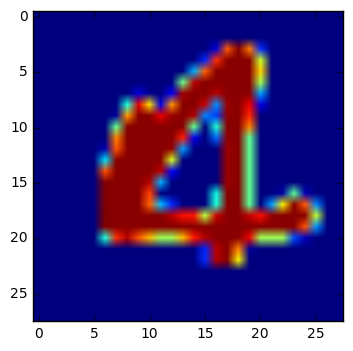

In [60]:
first_array=X_test1[3016].reshape([28,28])
p.imshow(first_array)
#Actually displaying the plot if you are not in interactive mode
p.show()
#Saving plot
plt.savefig("True_4_classified_to_0.png")